In [58]:
import time
import tracemalloc

tracemalloc.start()
st = time.time()

import os, psutil

from mpi4py import MPI
from petsc4py import PETSc
from dolfinx.io import gmshio 
from dolfinx.io import XDMFFile
from dolfinx.fem import (Expression, Function, FunctionSpace, VectorFunctionSpace)
from dolfinx.fem import (dirichletbc, locate_dofs_topological)
from dolfinx import *
from dolfinx import io

import ufl
from ufl import as_vector, dot, dx, grad, curl, inner, sqrt

from petsc4py.PETSc import ScalarType
import numpy as np

rank = MPI.COMM_WORLD.rank

In [59]:
model_rank = 0
mesh_comm = MPI.COMM_WORLD
gdim = 3

flag_visu = 0
flag_tet = 0

Ri = 0.1
th = 0.05
Ra = 0.3
la = 0.5

nl = 30
lc = th / 4


In [60]:
import gmsh

# Initialize Gmsh
gmsh.initialize()

# TODO change code (using function to generate all the mesh with defect of l , w ,d )
## next > add defect list 
# Read the .msh file
gmsh.open("mfl.msh")

# Optionally, you can specify the model name and dimension
model = gmsh.model
gdim = gmsh.model.getDimension()

# If needed, extract the mesh and tags
#mesh = gmsh.model.mesh.getNodes()
#cell_tags, facet_tags = gmsh.model.mesh.getTags()


mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)

# Finalize Gmsh
gmsh.finalize()

Info    : Reading 'mfl.msh'...
Info    : 145 entities
Info    : 96780 nodes
Info    : 606049 elements
Info    : Done reading 'mfl.msh'                                           


In [61]:
# Function space: edge elements
V0 = FunctionSpace(mesh, ("N1curl", 1))

# Create facet to cell connectivity required to determine boundary facets
dofs_facets = locate_dofs_topological(V0, mesh.topology.dim-1, facet_tags.find(4))

# Working boundary condition
u0 = Function(V0)
u0.x.set(0.)
bc = dirichletbc(u0, dofs_facets)

# Trial and test functions
u = ufl.TrialFunction(V0)
v = ufl.TestFunction(V0)

##Define Current Density (constant discontinuous)
V1 = VectorFunctionSpace(mesh, ("DG", 0))
J = Function(V1, dtype=ScalarType, name='Current_density')
cells1 = cell_tags.find(2)

J0 = 1e8
def Je(x, J0):
    return np.vstack([-J0*np.sin(np.arctan2(x[1],x[0]))*np.ones(x.shape[1]), J0*np.cos(np.arctan2(x[1],x[0]))*np.ones(x.shape[1]), np.zeros(x.shape[1])])

J.interpolate(lambda x: Je(x, J0), cells1)
J.x.scatter_forward()

#nu = 1e7 / (4*np.pi)
Q = FunctionSpace(mesh, ("DG", 0))
material_tags = np.unique(cell_tags.values)
nu = Function(Q)  
nu_ = 1e7 / (4*np.pi) # Vacuum

for tag in material_tags:
    cells = cell_tags.find(tag)
    # Set values for mu
    if tag == 3:
        nu_ = 1e7 / (4*np.pi) # Vacuum
    elif tag == 2:
        nu_ =  1e5 # Iron (This should really be 6.3e-3)
    elif tag == 11:
        nu_ = 1e5#  Iron (This should really be 6.3e-3)
    else:
        print("done")
    #elif tag == 1:
    #    nu_ =  1e7 / (4*np.pi)#1e7 / 1.26e-6 # Copper
    nu.x.array[cells] = np.full_like(cells, nu_, dtype=ScalarType)
 


a = nu * inner(curl(u), curl(v)) * dx
l = inner(J, v) * dx

A = Function(V0)
options = [ \
	{"ksp_type": "preonly", "pc_type": "lu", "ksp_monitor": None, "ksp_view": None}, \
	
	{"ksp_type": "gmres", "ksp_gmres_restart":30, "ksp_rtol":1e-6, "ksp_atol":1e-12, "ksp_max_it": 1000, "pc_type": "composite", "pc_composite_pcs": "sor,icc", "ksp_monitor": None, "ksp_monitor_true_residual": None, "ksp_view": None, "monitor_convergence": True}, \
	
	{"ksp_type": "gmres", "ksp_rtol":1e-6, "ksp_atol":1e-10, "ksp_max_it": 1500, "pc_type": "sor", "ksp_monitor": None, "ksp_view": None, "ksp_monitor_true_residual": None, "monitor_convergence": True}, \
	{"ksp_type": "lgmres", "ksp_rtol":1e-6, "ksp_atol":1e-10, "ksp_max_it": 1500, "pc_type": "ilu", "ksp_monitor": None, "ksp_view": None, "monitor_convergence": True}, \
	{"ksp_type": "pipefgmres", "ksp_rtol":1e-6, "ksp_atol":1e-10, "ksp_max_it": 1500, "pc_type": "ilu", "ksp_monitor": None, "ksp_view": None, "monitor_convergence": True}, \
	{"ksp_type": "bcgsl", "ksp_rtol":1e-6, "ksp_atol":1e-10, "ksp_max_it": 1000, "ksp_monitor": None, "ksp_view": None, "monitor_convergence": True}, \
	{"ksp_type": "ibcgs", "ksp_rtol":1e-6, "ksp_atol":1e-10, "ksp_max_it": 1000, "ksp_monitor": None, "ksp_view": None, "monitor_convergence": True}, \
	{"ksp_type": "cg", "ksp_rtol":1e-6, "ksp_atol":1e-10, "ksp_max_it": 1000, "ksp_monitor": None, "ksp_view": None, "monitor_convergence": True}, \
	{"ksp_type": "bicg", "ksp_rtol":1e-6, "ksp_atol":1e-10, "ksp_max_it": 1000, "ksp_monitor": None, "ksp_view": None, "monitor_convergence": True} \
	]
#"pc_factor_mat_solver_type": "umfpack", or mumps

problem = fem.petsc.LinearProblem(a, l, bcs = [bc], petsc_options = options[1])
A = problem.solve()

solver = problem.solver
solver.setFromOptions()
print("### SOLVE: DONE ###")
num_dofs_global = V0.dofmap.index_map.size_global * V0.dofmap.index_map_bs
print(f"Number of dofs: {num_dofs_global}")
print('Iteration number:', solver.getIterationNumber())
print('Iteration residual:', solver.getResidualNorm())

V2 = VectorFunctionSpace(mesh, ("DG", 1))
B = Function(V2, dtype=ScalarType, name='B_field')
B_expr = Expression(ufl.curl(A), V2.element.interpolation_points())
B.interpolate(B_expr)

V3 = FunctionSpace(mesh, ("DG", 1))
Bn = Function(V3, dtype=ScalarType, name='B_norm')
Bn_expr = Expression(ufl.sqrt(ufl.dot(B, B)), V3.element.interpolation_points())
Bn.interpolate(Bn_expr)
# TODO add loop to add I (fixed point based algorithm)
## 
print("Maximum B field (T)", Bn.x.array.max())

done
done
  Residual norms for dolfinx_solve_140294133468032 solve.
  0 KSP Residual norm 2.559491348810e+00 
  Residual norms for dolfinx_solve_140294133468032 solve.
  0 KSP preconditioned resid norm 2.559491348810e+00 true resid norm 2.938893354763e+06 ||r(i)||/||b|| 1.000000000000e+00
  1 KSP Residual norm 1.627515267097e+00 
  1 KSP preconditioned resid norm 1.627515267097e+00 true resid norm 3.625556181202e+06 ||r(i)||/||b|| 1.233646731456e+00
  2 KSP Residual norm 1.512884503025e+00 
  2 KSP preconditioned resid norm 1.512884503025e+00 true resid norm 3.675641903819e+06 ||r(i)||/||b|| 1.250689106450e+00
  3 KSP Residual norm 1.512848137305e+00 
  3 KSP preconditioned resid norm 1.512848137305e+00 true resid norm 3.695894373365e+06 ||r(i)||/||b|| 1.257580295445e+00
  4 KSP Residual norm 1.512420046295e+00 
  4 KSP preconditioned resid norm 1.512420046295e+00 true resid norm 3.739961899997e+06 ||r(i)||/||b|| 1.272574894198e+00
  5 KSP Residual norm 1.489810498729e+00 
  5 KSP prec

In [17]:
B.sub(0).vector.array.shape

(4410636,)

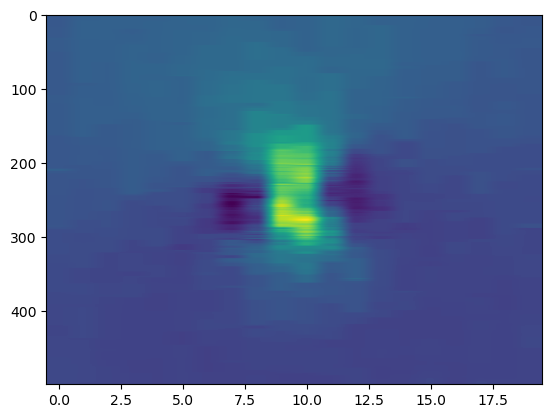

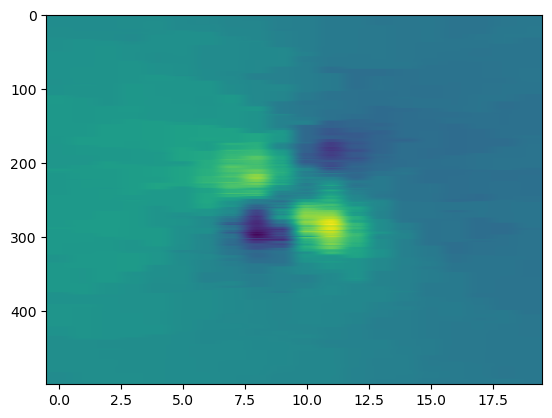

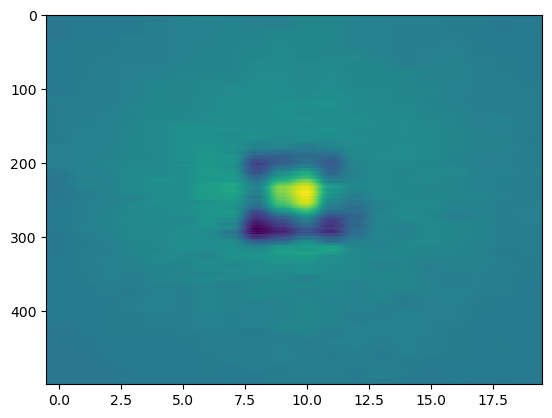

In [65]:
nbp = 500

B_view = B.sub(0).vector
Bx = np.zeros(shape=(nbp,20,3))
index = 0
for x in np.linspace(-1,1,20):
	y = np.linspace(-1, 1, nbp)
	points = np.zeros((gdim, nbp))
	points[0] = y
	points[1] = x
	points[2]= 0.35
	points
	Bn_values = []

	from dolfinx import geometry
	bb_tree = geometry.BoundingBoxTree(mesh, mesh.topology.dim)

	cells = []
	points_on_proc = []
	# Find cells whose bounding-box collide with the the points
	cell_candidates = geometry.compute_collisions(bb_tree, points.T)
	# Choose one of the cells that contains the point
	colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
	for i, point in enumerate(points.T):
		if len(colliding_cells.links(i)) > 0:
			points_on_proc.append(point)
			cells.append(colliding_cells.links(i)[0])
	points_on_proc = np.array(points_on_proc, dtype=np.float64)
	for k in range(3):
		B_values = B.sub(k).eval(points_on_proc, cells)
		Bx[:,index,k] = B_values[:,0]
	index+=1
	# TODO plot 2d H and B and with different lift off

import matplotlib.pyplot as plt
for k in range(3):
	plt.figure()
	plt.imshow(Bx[:,:,k], aspect="auto")
